# Analysis

I Have a few questions going into this. 
1. Does favorite submission really exist?
2. If favorite submission exists, does it have an impact on success rate?
3. What is the most "high percentage" submission in my sample?

In [1]:
import numpy as np
import pandas as pd
import re
import sqlite3
import time
from pytictoc import TicToc
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Read in athlete info
con = sqlite3.connect('bjj_network.db')
cur = con.cursor()
Athlete_Info = pd.read_sql_query('''SELECT * FROM Athlete_List''',con)
All_Matches = pd.read_sql_query('''SELECT * FROM Athlete_Matches''',con)
# Create Short Athlete_ID column
short_athlete_ID=pd.DataFrame(columns=['Short_Athlete_ID'],index=range(0,len(Athlete_Info['Athlete_ID'])))
for id in enumerate(Athlete_Info['Athlete_ID']):
    # print(id[0])
    short_athlete_ID.iloc[id[0],0] = id[1].split('-')[0]
Athlete_Info = Athlete_Info.join(short_athlete_ID)
Athlete_Info = Athlete_Info.drop(['level_0'],axis=1)
Athlete_Info = Athlete_Info.drop(['index'],axis=1)

Athlete_Info.head()


,Athlete_Name,Athlete_ID,Record,Birthdate,Short_Athlete_ID
0,"Aaron ""Tex"" Johnson",/people/6600946-aaron-tex-johnson,87-70-1,None,/people/6600946
1,Adam Wardzinski,/people/5950131-adam-wardzinski,180-52-2,None,/people/5950131
2,Alexssandro Sodre,/people/6749113-alexssandro-sodre,82-28-0,None,/people/6749113
3,Ana Carolina Vieira,/people/5950497-ana-carolina-vieira,47-12-0,November 19 1993,/people/5950497
4,Andre Galvao,/people/5951184-andre-galvao,165-31-2,September 29 1982,/people/5951184


In [3]:
# Get Rid of Extra Index Column
All_Matches = All_Matches.drop(['index'],axis=1)
# Create shortened versions of both athlete & Opponent ID so there are no names in the ID's
short_athlete_ID=pd.DataFrame(columns=['Short_Athlete_ID'],index=range(0,len(All_Matches['Athlete_ID'])))
for id in enumerate(All_Matches['Athlete_ID']):
    # print(id[0])
    short_athlete_ID.iloc[id[0],0] = id[1].split('-')[0]

short_opponent_ID=pd.DataFrame(columns=['Short_Opponent_ID'],index=range(0,len(All_Matches['Opponent_Link'])))
for id in enumerate(All_Matches['Opponent_Link']):
    # print(id[0])
    short_opponent_ID.iloc[id[0],0] = id[1].split('-')[0]
All_Matches = All_Matches.join(short_athlete_ID)
All_Matches = All_Matches.join(short_opponent_ID)

# Apparently some matches were recorded as an athlete fighting themselves so lets get rid of that
All_Matches = All_Matches[~All_Matches.apply(lambda x: x['Short_Athlete_ID'] == x['Short_Opponent_ID'], axis=1)]
# Drop Duplicates
All_Matches = All_Matches.drop_duplicates()
# Drop Unecessary Variables
All_Matches = All_Matches.drop(['Weight_Link'],axis=1)
All_Matches = All_Matches.drop(['Method_Link'],axis=1)
All_Matches = All_Matches.drop(['Event_Link'],axis=1)
All_Matches = All_Matches.drop(['Replay'],axis=1)
All_Matches = All_Matches.drop(['Replay_Link'], axis=1)
All_Matches = All_Matches.drop(['Date_Link'], axis=1)
All_Matches = All_Matches.drop(['W/L_Link'], axis = 1)

# Add Name based on ID

All_Matches = All_Matches.merge(Athlete_Info[['Athlete_Name','Short_Athlete_ID']],left_on = 'Short_Athlete_ID',right_on='Short_Athlete_ID',how='left')
All_Matches.rename(columns={'Athlete_Name':'athlete_name'},inplace=True)

All_Matches = All_Matches.merge(Athlete_Info[['Athlete_Name','Short_Athlete_ID']],left_on = 'Short_Opponent_ID',right_on='Short_Athlete_ID',how='left')
All_Matches.rename(columns={'Athlete_Name':'Opponent_Name'},inplace=True)

All_Matches.rename(columns={'athlete_name':'Athlete_Name'},inplace=True)
All_Matches.rename(columns={'Short_Athlete_ID_x':'Short_Athlete_ID'},inplace=True)
All_Matches = All_Matches.drop(['Short_Athlete_ID_y'],axis=1)


All_Matches.head()

,Athlete_ID,Year,Date,W/L,Method,Opponent,Opponent_Link,Weight,Event,Short_Athlete_ID,Short_Opponent_ID,Athlete_Name,Opponent_Name
0,/people/6600946-aaron-tex-johnson,2021,09/25,W,DQ,O. Sanchez,/people/6571306,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/6571306,"Aaron ""Tex"" Johnson",Orlando Sanchez
1,/people/6600946-aaron-tex-johnson,2021,09/25,L,Decision,T. Spriggs,/people/5950976,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/5950976,"Aaron ""Tex"" Johnson",Tim Spriggs
2,/people/6600946-aaron-tex-johnson,2021,07/09,L,Decision,G. Batista,/people/5952220,Absolute Division,Fight to Win 176,/people/6600946,/people/5952220,"Aaron ""Tex"" Johnson",Gustavo Batista
3,/people/6600946-aaron-tex-johnson,2021,06/18,W,Decision,L. Barbosa,/people/5951235,---,Fight to Win 174,/people/6600946,/people/5951235,"Aaron ""Tex"" Johnson","Lucas ""Hulk"" Barbosa"
4,/people/6600946-aaron-tex-johnson,2021,05/15,W,Other,J. Hansen,/people/6749112,Ultra Heavyweight,2021 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6600946,/people/6749112,"Aaron ""Tex"" Johnson",John Hansen


In [4]:
# Get only wins
Wins = All_Matches[All_Matches['W/L']=='W']
Wins.head()

,Athlete_ID,Year,Date,W/L,Method,Opponent,Opponent_Link,Weight,Event,Short_Athlete_ID,Short_Opponent_ID,Athlete_Name,Opponent_Name
0,/people/6600946-aaron-tex-johnson,2021,09/25,W,DQ,O. Sanchez,/people/6571306,Heavyweight,2021 FloGrappling WNO Championship,/people/6600946,/people/6571306,"Aaron ""Tex"" Johnson",Orlando Sanchez
3,/people/6600946-aaron-tex-johnson,2021,06/18,W,Decision,L. Barbosa,/people/5951235,---,Fight to Win 174,/people/6600946,/people/5951235,"Aaron ""Tex"" Johnson","Lucas ""Hulk"" Barbosa"
4,/people/6600946-aaron-tex-johnson,2021,05/15,W,Other,J. Hansen,/people/6749112,Ultra Heavyweight,2021 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6600946,/people/6749112,"Aaron ""Tex"" Johnson",John Hansen
5,/people/6600946-aaron-tex-johnson,2021,05/15,W,Other,L. Correa,,Ultra Heavyweight,2021 Pan IBJJF Jiu-Jitsu No-Gi Championship,/people/6600946,,"Aaron ""Tex"" Johnson",NaN
8,/people/6600946-aaron-tex-johnson,2021,03/28,W,Outside Heel Hook,G. Bodoni,/people/6800513,Absolute Division,2021 IBJJF Orlando No-Gi International Open,/people/6600946,/people/6800513,"Aaron ""Tex"" Johnson",Giancarlo Bodoni


In [5]:
# Drop data when we don't know the athlete or it was more than 5 years ago
Wins = Wins.dropna(subset = ['Athlete_Name'])
Wins = Wins[Wins['Year']>='2018']

In [7]:
Wins.tail()

,Athlete_ID,Year,Date,W/L,Method,Opponent,Opponent_Link,Weight,Event,Short_Athlete_ID,Short_Opponent_ID,Athlete_Name,Opponent_Name
38242,/people/6801896,2020,07/24,W,Decision,G. Alef,/people/6811140,175lbs,Fight to Win 148,/people/6801896,/people/6811140,Justin Renick,NaN
38244,/people/6801896,2020,07/10,W,Decision,M. Cox,/people/6801824,185lbs,Fight to Win 146,/people/6801896,/people/6801824,Justin Renick,Matthew Cox
38246,/people/6801896,2020,05/15,W,RNC,A. Culpepper,/people/6808761,210lbs,Fight to Win 139,/people/6801896,/people/6808761,Justin Renick,NaN
38250,/people/6808489,2021,08/06,W,Decision,C. Marasigan,,---,Fight to Win 180,/people/6808489,,Michael John,NaN
38252,/people/6808489,2018,04/20,W,Other,H. Gozali,/people/6809061,180lbs,Fight 2 Win Pro 71,/people/6808489,/people/6809061,Michael John,NaN


## Now that the data is loaded up, lets see what our submissions look like

In [9]:
Wins['Method'].unique()

array(['DQ', 'Decision', 'Other', 'Outside Heel Hook', 'Knee Bar',
       'Advantage', 'Armlock', 'Straight Ankle Lock', 'Points',
       'Ankle Lock', 'Armbar', 'Heel Hook', 'Kimura', 'Inside Heel Hook',
       'Split Decision', 'Triangle', 'Footlock', 'Calf Slicer',
       'Choke From the Back', 'Ezekiel Choke', 'Bow and Arrow',
       'Katagatame', 'Choke', 'RNC', 'Shoulder Lock', 'Cross Choke',
       'Penalty', 'Omoplata', 'Arm Triangle Choke', 'Lapel Choke',
       'Ezekiel', 'Golden Score', 'Flying Triangle', 'OT', 'Toehold',
       'Choke from Mount', 'Choke from Crucifix', 'Guillotine', 'Injury',
       'Reverse Triangle', 'OT Takedown', 'Triangle Arm Bar',
       'Wrist Lock', 'Darce Choke', 'Cachecol Choke', 'Estima Lock',
       'Americana', 'Collar Choke', 'Anaconda Choke', 'N/A - Draw',
       'Arm in Guillotine', 'Triangle Choke', 'Baratoplata', 'Twister',
       'Mounted Triangle', 'Clover Leaf', 'Riding Time', 'Brabo Choke',
       'Double Collar Choke', 'Bread and But

How many in each category?

In [16]:
Wins['Count']=1
Submission_Freq = Wins.groupby(['Method'])['Count'].sum().reset_index()
Submission_Freq.head()

,Method,Count
0,Advantage,776
1,Americana,11
2,Anaconda Choke,13
3,Ankle Lock,20
4,Arm Triangle Choke,16


In [44]:
pd.set_option('display.min_rows',30)

In [45]:

total = Submission_Freq['Count'].sum()
Submission_Freq['Pct'] = Submission_Freq['Count']/total * 100

Submission_Freq.sort_values(by='Count',ascending=False)

,Method,Count,Pct
55,Points,3853,29.778190
51,Other,2733,21.122189
25,Decision,1309,10.116701
0,Advantage,776,5.997372
6,Armbar,587,4.536672
17,Choke From the Back,519,4.011129
56,RNC,417,3.222815
63,Triangle,259,2.001700
16,Choke,249,1.924415
37,Inside Heel Hook,158,1.221114


The above shows that the majority of matches (~67%) are finished by Points (30%), Other (21%), Decision (10%), or Advantage (6%).

Before we continue, I would assert that this is a meaningful finding. While not included in my original plan, submissions are the minority in brazilian jiu jitsu matchs. Looking soley at submissions is likely ignoring a large part of what creates success as a competitor. While I'm not sure what FloGrappling defines as "Other", this suggests that "hustling" or "being first" is a large factor in success. Being aggresive and getting a takedown in the first few seconds could give you the point advantage necessary to win, since a match being decided on points is only slightly less likely than a match ending in any submission (30% vs 33%).



## Next we'll remove all non submissions to see how they compare

In [77]:
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Penalty'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Split Decision'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Decision'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Points'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'DQ'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Advantage'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Other'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'N/A - Draw'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'OT'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Injury'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'OT Takedown'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Golden Score'].index,inplace=True)
Submission_Freq.drop(Submission_Freq[Submission_Freq['Method'] == 'Riding Time'].index,inplace=True)


## At this point we have decisions to make

Many of these submissions could be classified as different groups, for example a loop choke is a lapel choke and the darce choke anaconda choke, and brabo choke are all very similar and fall into the category of arm triangle choke. 

I have decided to leave all of the submissions alone for this, largely because there is an element of individual variation with all moves, but also because I don't have video evidence to reclassify the submission.

In [78]:
Submission_Freq['Method'].unique()

array(['Americana', 'Anaconda Choke', 'Ankle Lock', 'Arm Triangle Choke',
       'Arm in Guillotine', 'Armbar', 'Armlock', 'Baratoplata',
       'Baseball Bat Choke', 'Bow and Arrow', 'Brabo Choke',
       'Bread Cutter Choke', 'Bread and Butter', 'Cachecol Choke',
       'Calf Slicer', 'Choke', 'Choke From the Back',
       'Choke from Crucifix', 'Choke from Mount', 'Clover Leaf',
       'Collar Choke', 'Cross Choke', 'Darce Choke',
       'Double Collar Choke', 'Electric Chair', 'Estima Lock', 'Ezekiel',
       'Ezekiel Choke', 'Flying Triangle', 'Footlock', 'Guillotine',
       'Heel Hook', 'Inside Heel Hook', 'Katagatame', 'Kimura',
       'Knee Bar', 'Lapel Choke', 'Leg Lock', 'Loop Choke', 'Mir Lock',
       'Mounted Triangle', 'Neck Crank', 'Omoplata', 'Outside Heel Hook',
       'Paper Cut Choke', 'RNC', 'Reverse Triangle', 'Shoulder Lock',
       'Straight Ankle Lock', 'Toehold', 'Triangle', 'Triangle Arm Bar',
       'Triangle Choke', 'Twister', 'Wrist Lock'], dtype=object)

In [79]:
Submission_Freq['Pct'] = Submission_Freq['Count']/Submission_Freq['Count'].sum()
Submission_Freq.shape

(55, 3)

In [80]:
Submission_Freq.sort_values(by=['Count'],ascending=False)

,Method,Count,Pct
6,Armbar,587,0.155662
17,Choke From the Back,519,0.137629
56,RNC,417,0.110581
63,Triangle,259,0.068682
16,Choke,249,0.066030
37,Inside Heel Hook,158,0.041899
35,Heel Hook,150,0.039777
61,Straight Ankle Lock,147,0.038982
40,Knee Bar,147,0.038982
62,Toehold,132,0.035004


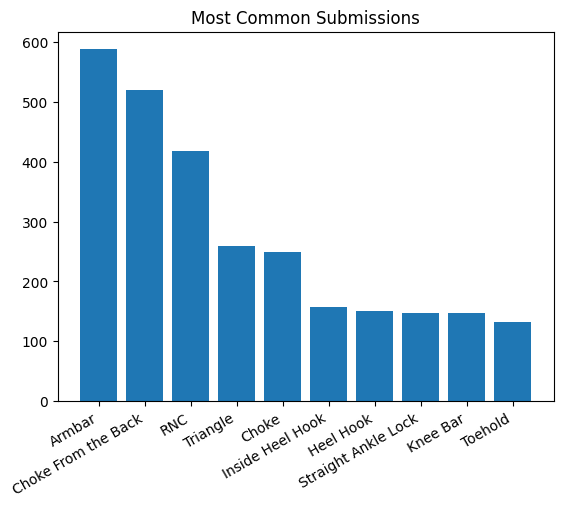

In [86]:
plt.title('Most Common Submissions')
plt.bar(Submission_Freq.sort_values(by=['Count'],ascending=False).iloc[0:10,0],Submission_Freq.sort_values(by=['Count'],ascending=False).iloc[0:10,1])
plt.xticks(rotation=30,ha='right')
plt.show()

plt.bar(Submission_Freq['Method'],Submission_Freq['Count'])